### Acoustic Well Sensing

The data in this notebook comes from the job depicted in this screenshot, where we can see that offset well communication is happening because the offset wells are going up in pressure as the pressure increases in the well that is being completed.  In this case the offset wells are on a different pad ~1/2 mile away. We see communication in the closest wellbore first, and the 2nd closest wellbore 2nd (delayed poroelastic response). 

![example communication](images/communication_example.png)

### Events to detect
 * start of pumping down the perf guns and plugs
 * end of pumping down the perf guns and plugs
 * firing off perf guns
 * start of frac stage
 * detect steep pressurization step in the stage
 * end of frac stage
 * pressurizing to create fractures
 * fractures occurring on active fracking well measuring on active fracking well
 * fractures occuring on active fracking well measuring on offset well
 * detecting signs of well communication
 * detecting communication correlation
 * Detect gear shift (false positive, looks alot like the "pops" when we are fracking, only occurs early in stage

### Goal 
 * produce a fracture report in near real-time
     - log every detected fracture with a timestamp
     - characterize their magnitude, count, detect a seam that cracks rapidly in succession
 * detect early signs of communication using dynamic sensors before we see a static pressure increase in the offset well
     - produce a communication event/alert so that the operator can decide whether they want to continue or not

In [109]:
%load_ext autoreload
%autoreload 2

import os
import sys
base_path = os.environ['basepath']
if base_path not in sys.path:
    sys.path.append(base_path)
os.chdir(base_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import datetime
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.fft as fft

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook

import librosa
import db

In [111]:
plt.rcParams["figure.figsize"] = (20,6)
db.init()

In [112]:
def table_cols(table):
    return db.query(f"""SELECT *
  FROM information_schema.columns
 WHERE table_schema = 'public'
   AND table_name   = '{table}';""")

def sensor_info(api):
    return db.query(f"""SELECT sensors.id
FROM wells
JOIN sensors ON sensors.well_id = wells.id
JOIN sensor_models ON sensors.sensor_model_id = sensor_models.id
WHERE api = '{api}' AND pressure_type = 'static'""")

def static_sensor_data(sensor_id, start_time, end_time):
    return db.query_dataframe(f"""SELECT max FROM sensor_data where sensor_id = '{sensor_id}' AND time BETWEEN '{start_time}' AND '{end_time}' ORDER BY time ASC""")

def name_to_api(name, number):
    return db.query(f"""select api from wells where wells.name like '%{name}%' AND number = '{number}'""")


In [113]:
api = name_to_api("BRISCOE CATARINA", "33HU")[0][0]
sensor_id = sensor_info(api)[0][0]
start_time = datetime.datetime(year=2020, month=1, day=8, hour=0, minute=0, second=0).isoformat()
end_time = datetime.datetime(year=2020, month=1, day=8, hour=3, minute=30, second=0).isoformat()
static_data = static_sensor_data(sensor_id, start_time, end_time)

In [114]:
dynamic_npys = []
hours = [0, 1, 2, 3]
for hour in hours:
    npy = np.load(f'data/well-communication/BRISCOE-CATARINA-WEST_33HU_dynamic_c62e0d73-2b63-4fba-8a6a-fd96466b545d_2020-01-08T0{hour}:00:00.000Z.npz')
    dynamic_npys.append(npy['arr_0'])
    
dynamic_data = np.concatenate(dynamic_npys)

In [121]:
sampling_rate = int(len(dynamic_data) / (60 * 60))

In [115]:
def windowed_average(arr, n):
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

def windowed_max(arr, n):
    end =  n * int(len(arr)/n)
    return np.max(arr[:end].reshape(-1, n), 1)

In [116]:
dynamic_data_secs = windowed_max(dynamic_data, 40000)

In [117]:

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

    
def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal


In [118]:
# TODO: find a region of the data that is just noise

#output = removeNoise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip,verbose=True,visual=True)

# fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
# plt.plot(output, color='black')
# ax.set_xlim((0, len(output)))
# plt.show()
# # play back a sample of the song
# IPython.display.Audio(data=output, rate=44100)

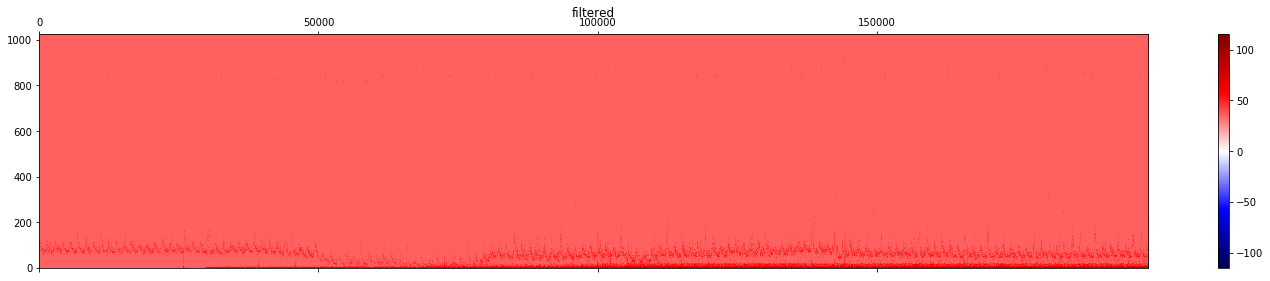

In [122]:
n_fft=2048
win_length=2048
hop_length=512
y = dynamic_data[:600 * sampling_rate]

# n_fft (int): number audio of frames between STFT columns.
# win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
# hop_length (int):number audio of frames between STFT columns.
y_spectrum = _stft(y, n_fft, hop_length, win_length)
y_spectrum_db = _amp_to_db(np.abs(y_spectrum))  # convert to dB
plot_spectrogram(y_spectrum_db, title="filtered")

In [123]:
def high_pass_filter(xn, cutoff_freq, sampling_rate=40000):
    # Create a highpass butterworth filter at 150 Hz
    filter_order = 10
    sos = signal.butter(filter_order, cutoff_freq, btype='highpass', fs=sampling_rate, output='sos')
    y = signal.sosfilt(sos, xn)
    return y

#     size = len(times)
#     offset = 0.0
#     portion = 0.1
#     a = int(offset * size)
#     b = int((offset + portion) * size)
#     n = b - a
    
def plot_spectrogram(times, freqs, spectrums, gamma=0.3):
    min_v = spectrums.min()
    max_v = spectrums.max()
    vmin = 0.0
    vmax = 2000.0
    fig, ax = plt.subplots(figsize=(24,4))
    #normalizer = colors.Normalize(vmin=vmin,vmax=vmax)
    #normalizer = colors.LogNorm(vmin=vmin, vmax=vmax)
    normalizer = colors.PowerNorm(gamma=gamma)
    pcm = ax.pcolormesh(times[a:b], freqs, spectrums[:,:n],
                        norm=normalizer,
                        cmap='Spectral')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    fig.colorbar(pcm)
    plt.show()
    
def plot_spectrogram_b(signal, grid=True):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.spectral,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    plt.grid(grid)
    fig.colorbar(cax)

def spectrogram(xn, sampling_rate=40000):
    window_size = 1024
    overlap = window_size / 4
    scaling = 'spectrum' # 'density' or 'spectrum'
    mode = 'magnitude'
    freqs, times, spectrums = signal.spectrogram(xn, sampling_rate, 
                                                 nperseg=window_size, noverlap=overlap, 
                                                 return_onesided=True, scaling=scaling, mode=mode)
    return freqs, times, spectrums

def find_peaks(xn, min_prominence=30, min_spacing=2):
    peaks, props = signal.find_peaks(y, prominence=min_prominence, distance=min_spacing)
    return peaks

def plot_peaks(peaks, y):    
    plt.plot(peaks, y[peaks], '.')


In [125]:
start = 30 * 60 * sampling_rate
end = start + (1 * 60 * sampling_rate)
xn = dynamic_data[start:end]
t = range(len(xn))
y = high_pass_filter(xn, 150)
#peaks = find_peaks(y)
#neg_peaks = find_peaks(-y)
pos_peaks, neg_peaks = peakdetect.peakdetect(y, lookahead=80, delta=18)
peaks = pos_peaks + neg_peaks
freqs, times, spectrums = spectrogram(y)

NameError: name 'peakdetect' is not defined

NameError: name 'peaks' is not defined

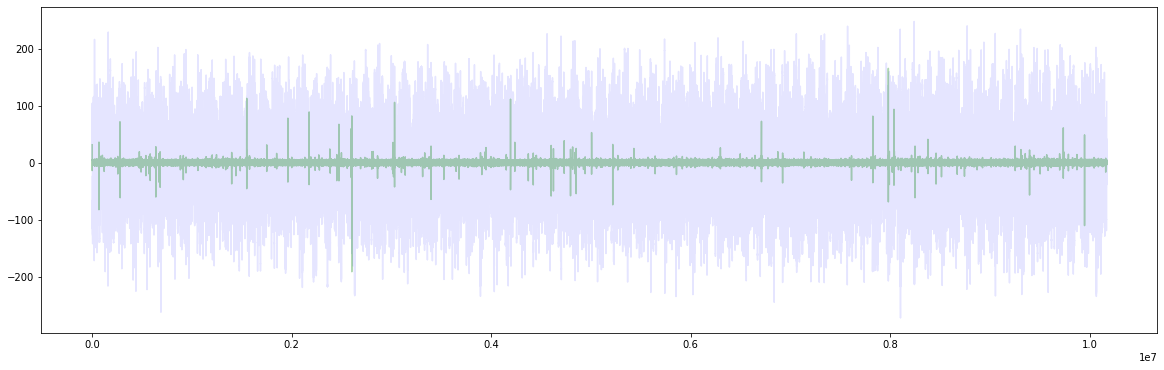

In [126]:
# Plot the original signal and the various filtered versions:
plt.figure
#plt.grid(True)
plt.plot(t, xn, 'blue', alpha=0.1)
plt.plot(t, y, 'green',alpha=0.3)
plt.plot([x for x,y in peaks], [y for x,y in peaks], '.')
plt.tight_layout()
plt.show()

In [ ]:
plot_spectrogram(times, freqs, spectrums / spectrums.max(), gamma=0.05)

In [127]:
sig = _amp_to_db(np.abs(spectrums / spectrums.max()))
fig, ax = plt.subplots(figsize=(20, 4))
cax = ax.matshow(
    sig,
    origin="lower",
    aspect="auto",
    cmap=plt.cm.Spectral,
    vmin=-1 * np.max(np.abs(sig)),
    vmax=np.max(np.abs(sig)),
)
plt.grid(True)
fig.colorbar(cax)
plt.show()

NameError: name 'spectrums' is not defined

## frac types
* created by pressure
* created by propping
* remain after letting off pressure

* Watch the well after the job completes to see what's happening, further fractures or closures, etc.
* execution package vs frack optimization package

* diagnose when plugs shear, or when guns get stuck
* correlate fracture initiation score with static pressure to try to understand whether fractures are long, straight tubes or complex networks that resist flow
 - the pumps are maintaining a flow rate, not a pressure, so the flow is restricted in complex networks
* correlate the frac score with the RTA (rate transient analysis) which is computed after about 120 days


* total perforations
* perfs per cluster
* compartment length
* concentration and sand type
* volume
* chemicals
* fluid type


In [ ]:
plt.bar(peaks, y[peaks])
plt.show()

In [ ]:
n_fft=2048
win_length=2048
hop_length=512

# n_fft (int): number audio of frames between STFT columns.
# win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
# hop_length (int):number audio of frames between STFT columns.
y_spectrum = _stft(y, n_fft, hop_length, win_length)
y_spectrum_db = _amp_to_db(np.abs(y_spectrum))  # convert to dB
plot_spectrogram(y_spectrum_db, title="filtered")

In [ ]:
# plt.hist(a, bins='auto')  # arguments are passed to np.histogram
# >>> plt.title("Histogram with 'auto' bins")
# Text(0.5, 1.0, "Histogram with 'auto' bins")
# >>> plt.show()
counts, bin_edges = np.histogram(spectrums, bins=100)
plt.show()

fig, ax = plt.subplots()
ax.bar(bin_edges[2:], counts[1:])
ax.set_yscale('log')
plt.show()